<mark> <font size="3"> Suman Pan - 218352 </mark>


<mark> <font size="3"> Clara Llòria - 218147 </mark>

# Lab 6: Sructure from motion

## Goals
The goal of the current assignment is to learn the following concepts:

- How to self-calibrate a camera using vanishing points.
- What are the main elements of an incremental structure from motion approach.

## Introduction

The Structure fron Motion problem (SfM) is defined as the 3D reconstruction from a set of unordered and uncalibrated images. There are different SfM approaches: global, hierarchical or incremental. In this lab we will focus on the incremental SfM, which is the most popular strategy for 3D reconstruction from unordered and uncalibrated photo collections.

Incremental SfM is a sequential processing pipeline with an iterative component. It starts working from two views, from which motion (camera parameters) are initialized, and then the structure (3D reconstruction) is also initialized. Right after, an iterative extension of both the motion and the structure is performed, progressively adding new cameras/views and 3D points. A further refinement of both the camera matrices and the reconstructed point cloud is carried out. This last step is known as Bundle Adjustment and it involves solving an optimization problem by iterative techniques.

The purpose of this lab is to familiarize with the structure from motion problem and work with the main blocks that constitute a basic (vanilla) incremental SfM algorithm, without the refinement step. A more complete and robust SfM pipeline would include -- a part from the bundle adjustment --  a carefully selection of the two initial views and each next new view to incorporate, filtering of outliers,  and some other tricks [3]. If you are interested in a more complete solution here we provide a list of some of the most known libraries and softwares:

- OpenMVG:  http://openmvg.readthedocs.io/en/latest/# <br>
Incremental and global SfM, open source.

- VisualSFM:  http://ccwu.me/vsfm/ <br>
Incremental SfM, very efficient, GUI, binaries.

- Bundler: http://www.cs.cornell.edu/~snavely/bundler/ <br>
Incremental SfM, open source.

- Colmap: http://colmap.github.io/ <br>
Incremental SfM, very efficient, nice GUI, open source.

- Theia: http://www.theia-sfm.org/ <br>
Incremental and Global SfM, very efficient, open source.

The solution of the structure from motion strongly relies on point correspondences (matchings) across the different views, commonly known as feature tracks. Then, one of the first things to do is feature extraction and matching, followed by geometric verification to remove outliers. 

As in previous labs, we will be using ORB / SIFT for estimating keypoints and matchings between pairs of images.  These matchings will contain outliers; these can be filtered by robustly estimating a fundamental matrix. Moreover, the fundamental matrix that relates the two initial views will be used to estimate the camera parameters (motion) of these two views.

**Q1.** Robustly estimate the fundamental matrix (F) that relates views 1 and 2, and views 1 and 3. To compute F use the python function cv2.findFundamentalMat, take a close look at the documentation before using it (which are the inputs and what dimesion they should have). For each case, display the inlier matchings together with the pair of images.


In [1]:
from numpy import linalg as LA
import math
import random
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import plotly.graph_objects as go


In [157]:
def compute_pts(img1, img2):
    # Initiate SIFT detector
    sift = cv2.SIFT_create(3000)

    # find the keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # Keypoint matching
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)

        # Apply ratio test
    good_matches = []
    for m,n in matches:

        if m.distance < 0.85*n.distance:
            good_matches.append([m])
            
    # Show matches
    img_12 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_12)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()
    
#     pts1 = []
#     pts2 = []

#     for i,(m) in enumerate(matches):
#         pts2.append(kp2[m.trainIdx].pt)
#         pts1.append(kp1[m.queryIdx].pt)
#     pts1  = np.asarray(pts1)
#     pts2 = np.asarray(pts2)

    points1 = []
    points2 = []
    for m in good_matches:
        points1.append([kp1[m[0].queryIdx].pt[0], kp1[m[0].queryIdx].pt[1], 1])
        points2.append([kp2[m[0].trainIdx].pt[0], kp2[m[0].trainIdx].pt[1], 1])

    points1 = np.asarray(points1)
#     points1 = points1.T
    points2 = np.asarray(points2)
#     points2 = points2.T
    
    return points1, points2, good_matches


In [165]:
def computeFundamentalMatrix(img1, img2):
    # Reduce image size to speed up computations
    scale_percent = 50
    width = int(img1.shape[1] * scale_percent / 100)
    height = int(img1.shape[0] * scale_percent / 100)
    dsize = (width, height)
    img1r = cv2.resize(img1, dsize)
    img2r = cv2.resize(img2, dsize)

    pts1, pts2, matches = compute_pts(img1r, img2r)
    print("total number of points pts1 and pts2: ",np.shape(pts1),np.shape(pts2))

    threshold = 3
    prob = 0.99
    F = cv2.findFundamentalMat(pts1, pts2,cv2.FM_RANSAC, threshold, prob)
    return F[0]

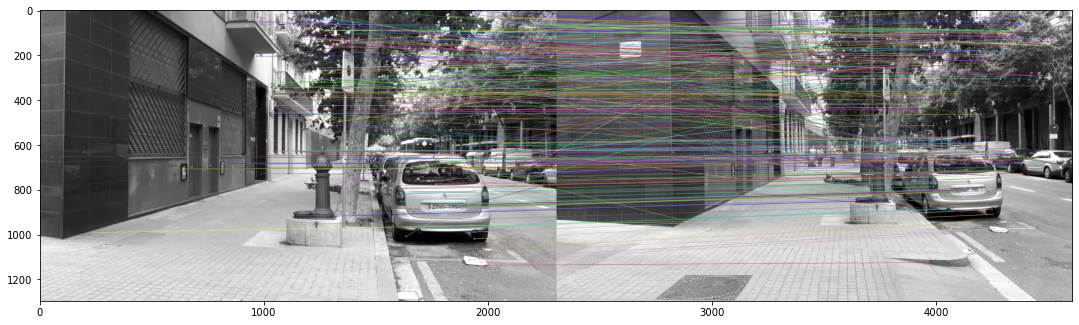

total number of points pts1 and pts2:  (369, 3) (369, 3)


In [166]:
# Read images
img1 = cv2.imread('images/eview1.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('images/eview3.jpg',cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('images/eview2.jpg',cv2.IMREAD_GRAYSCALE)

F12 = computeFundamentalMatrix(img1, img2)

## Initial two-view reconstruction and self-calibration
In lab 5 we saw how to recover the motion between a pair of calibrated cameras. In SfM cameras are not calibrated, but different self-calibration techniques can be applied for estimating the intrinsic parameters.
 
In case we work with images of man-made environments, like urban or indoor scenes, it is possible to estimate vanishing points of orthogonal directions. Vanishing points are useful for self-calibration because they allow us to establish constraints on the internal parameters of the camera (intrinsics). There are different methods in the literature to estimate vanishing points. For example, the following ones are implemented in Matlab:

- Vanishing Point Detection in Urban Scenes Using Point Alignments [1, 2]: <br>
http://www.ipol.im/pub/art/2017/148/

- Orthogonal Vanishing Points in Uncalibrated Images of Man-Made Environments [4]: <br>
https://members.loria.fr/GSimon/software/fastvp/

And this other one in Python:
- NeurVPS: Neural Vanishing Point Scanning via Conic Convolution: [6] <br>
https://github.com/zhou13/neurvps

We will assume square pixels (aspect ratio of 1), zero skew factor and principal point at the center of the image, which is common in most commercial cameras.  Then, the only remaining unknown in the matrix of internal parameters is the focal length $\alpha$, but it can be estimated using a pair of vanishing points as we will explain now (see also Section 6.3.2 of Szeliski's book [5]). 

Under the previous assumptions, the camera calibration matrix, $K$, can be written as: <br>
$$ K=\begin{pmatrix} \alpha & 0 & c_x \\ 0 & \alpha & c_y \\ 0 & 0 & 1\end{pmatrix}$$
where the only unknown is $\alpha$, since $c_x = \frac{w}{2}$ and $c_y = \frac{h}{2}$, being $w$ and $h$, respectively, the image width and height in pixels. 

Let us assume that we have detected two or more orthogonal vanishing points, all of which are finite, i.e., they are not obtained from lines that appear to be parallel in the image plane. The projection equation for the vanishing point $\mathbf{v}_1$ corresponding to the cardinal direction $(1, 0, 0)^T$ can be written as
$$ \mathbf{v}_1 \sim K  \begin{pmatrix}\mathbf{r}_1 & \mathbf{r}_2 & \mathbf{r}_3 & \mathbf{t} \end{pmatrix} \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \end{pmatrix} = K \mathbf{r}_1$$
If we denote the coordinates of the vanishing point $\mathbf{v}_1$ as $x_1$ and $y_1$ we have:
$$ \mathbf{r}_1 \sim K^{-1} \mathbf{v}_1 = \begin{pmatrix} 1/\alpha & 0 & -c_x/\alpha \\ 0 & 1/\alpha & -c_y/\alpha \\ 0 & 0 & 1 \end{pmatrix} 
 \begin{pmatrix} x_1 \\ y_1 \\ 1 \end{pmatrix} = 
 \begin{pmatrix} x_1 - c_x \\ y_1 -c_y \\ \alpha \end{pmatrix}$$
And in general, for the vanishing point $\mathbf{v}_i$, $i=1,2,3$, corresponding to one of the cardinal directions (1, 0, 0), (0, 1, 0), or (0, 0, 1) respectively, and $\mathbf{r}_i$ being the $i$th column of the rotation matrix $R$ we have:
$$ \mathbf{r}_i \sim  \begin{pmatrix} x_i - c_x \\ y_i -c_y \\ \alpha \end{pmatrix}$$
From the orthogonality between columns of the rotation matrix, we have:
$$ \mathbf{r}_i  \cdot \mathbf{r}_j = (x_i - c_x)(x_j - c_x)+(y_i - c_y)(y_j - c_y)+ \alpha^2 =0, $$
from which we can obtain an estimate for $\alpha$:
$$ \alpha = \sqrt{-(x_i - c_x)(x_j - c_x)-(y_i - c_y)(y_j - c_y)}.$$
Then, it is possible to estimate $\alpha$, and thus $K$, using two vanishing points corresponding to orthogonal directions. In our case, all the images have been taken with the same camera, so all of them will share the same $K$.

**Q2.** Provide the code to estimate the matrix of internal parameters following the previous directions. Which is the matrix you have obtained?

In the first part of the lab we have estimated the fundamental matrix $F$ that relates the initial pair of views. With $F$ and $K$ we can estimate the essential matrix $E$ and from it we can get the complete camera matrices (intrinsics and extrinsics) for the initial pair of views. Once the cameras are fully calibrated an initial 3D reconstruction (structure) is found by triangulation. Those steps were part of lab 4.


**Q3.** Estimate the camera matrices for views 1 and 2. 

In [ ]:
np.shape(img3r)

In [162]:
import scipy.io as sio

def compute_K():
    mat_content = sio.loadmat('./view1_vp.mat')
    vps=mat_content['horizon_vp']

    vp1 = vps[0,:] # contains the coordinates of the 1st vanishing point\n",
    vp2 = vps[1,:] # contains the coordinates of the 2nd vanishing point\n",

    print(vps)
    cx = width/2
    cy = height/2


    alpha = np.sqrt(-(vp1[0]-cx)*(vp2[0]-cx) - (vp1[1]-cy)*(vp2[1]-cy))
    K = np.array([[alpha, 0, cx], [0, alpha, cy], [0, 0, 1]])
    return K

In [163]:
K = compute_K()

[[16498.7424327   1337.61340352]
 [  932.90698134   963.98844082]]


**Q4.** Triangulate the matches from views 1 and 2 and plot them together with the cameras.

In [101]:
# our own functions of lab4
# TODAS ESTAS FUNCIONES + LAS DE ABAJO SE PODRÍAN COPIAR A UN UTILS.PY
def compute_E(F, K):
    K_p = K
    E = np.dot(K_p.T, np.dot(F,K))
    return E

def compute_P1(K):
    zero_vec = np.zeros([1,3])
    I_m = np.identity(3)
    P_bar = np.concatenate([I_m,zero_vec.T], axis = 1)
    P1 = np.dot(K, P_bar) # camera 1
#     print(P1)
    return P1

def compute_P2(E, K):
    U,D,VT = LA.svd(E)

    # The SVD of E has several ambiguities.  In particular, U and V may be
    # improper rotations in which case we need to change their sign.
    if LA.det(U) < 0:
        U = -U

    if LA.det(VT) < 0:
        VT = -VT

    # four camera projection matrices for the second camera
    W = np.asarray([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

    Pc2 = np.empty(shape=(4,3,4))
    UWVT =  np.dot(U,np.dot(W, VT))
    UWTVT = np.dot(U,np.dot(W.T, VT))

    Pc2[0] = np.dot(K, np.concatenate((UWVT, U[:,-1,np.newaxis]), axis = 1))
    Pc2[1] = np.dot(K, np.concatenate((UWVT, -U[:,-1,np.newaxis]), axis = 1))

    Pc2[2] = np.dot(K, np.concatenate((UWTVT, U[:,-1,np.newaxis]), axis = 1))
    Pc2[3] = np.dot(K, np.concatenate((UWTVT, -U[:,-1,np.newaxis]), axis = 1))

    return Pc2  

def chose_right_P2(P1, Pc2, x1, x2, nx=2, ny=2):
    for P2i in Pc2:

        Xi = triangulate(x1[:,0], x2[:,0], P1, P2i, [nx, ny])
        Xi = Xi / Xi[3][np.newaxis]
        
        x1est = P1 @ Xi
        x2est = P2i @ Xi
        
        if (x1est[2] > 0) and (x2est[2] > 0):
            P2 = P2i
            break
            
    return P2

def triangulate(x1, x2, P1, P2, imsize):

    # only one point
    if x1.ndim == 1:
        x1 = np.array([x1]).T
        x2 = np.array([x2]).T

    # number of points
    n = x1.shape[1]

    # Normalization
    x1 = x1/x1[2,:]
    x2 = x2/x2[2,:]

    nx = imsize[0];
    ny = imsize[1];

    H = [[2/nx,  0,     -1],
        [0,      2/ny,  -1],
        [0,      0,      1]]
    
    x1_norm = H @ x1
    x2_norm = H @ x2
    P1_norm = H @ P1img1 = cv2.imread('images/eview1.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('images/eview3.jpg',cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('images/eview2.jpg',cv2.IMREAD_GRAYSCALE)
    P2_norm = H @ P2
    
    # we dont have to denormalize, since we are just modifying the equation not the interest points X
    # that is, transforming it back using H^-1
    
    num_points = x1_norm.shape[1]
    X = np.zeros((4,num_points))
    for i in range(num_points): #8 points
        # first view
        a1= x1_norm[0,i] * P1_norm[2,:] - P1_norm[0,:] 
        a2= x1_norm[1,i] * P1_norm[2,:] - P1_norm[1,:]
        # second view
        a3= x2_norm[0,i] * P2_norm[2,:] - P2_norm[0,:] 
        a4= x2_norm[1,i] * P2_norm[2,:] - P2_norm[1,:]
        

        Ai = np.asarray([a1,a2,a3,a4]) # 4x4
        
        u,s,vh = np.linalg.svd(Ai)
        xi = vh[-1,:] #last row

        X[:,i]=xi
    
    # normalization of X to homogeneous space
    X /= X[-1, :]

    return X


In [53]:

    print((np.shape(X)[0]))

NameError: name 'X' is not defined

In [148]:
def view_direction(P, x):
    # Vector pointing to the viewing direction of a pixel
    # We solve x = P v with v(3) = 0
    v = np.linalg.inv(P[:,:3]) @ np.array([x[0], x[1], 1])
    return v

def plot_camera(P, w, h, fig, legend, scale=1):
    
    o = optical_center(P)
    
    p1 = o + view_direction(P, [0, 0]) * scale
    p2 = o + view_direction(P, [w, 0]) * scale
    p3 = o + view_direction(P, [w, h]) * scale
    p4 = o + view_direction(P, [0, h]) * scale
    
    x = np.array([p1[0], p2[0], o[0], p3[0], p2[0], p3[0], p4[0], p1[0], o[0], p4[0], o[0], (p1[0]+p2[0])/2])
    y = np.array([p1[1], p2[1], o[1], p3[1], p2[1], p3[1], p4[1], p1[1], o[1], p4[1], o[1], (p1[1]+p2[1])/2])
    z = np.array([p1[2], p2[2], o[2], p3[2], p2[2], p3[2], p4[2], p1[2], o[2], p4[2], o[2], (p1[2]+p2[2])/2])
    
    fig.add_trace(go.Scatter3d(x=x, y=z, z=-y, mode='lines',name=legend))
    
    return


def optical_center(P):
    U, d, Vt = np.linalg.svd(P)
    o = Vt[-1, :3] / Vt[-1, -1]
    return o


In [36]:
np.shape(K)

(3, 3)

In [153]:

def triangulate_all_matches(x1, x2, P1, P2, nx1, ny1, img1):
    X = triangulate(x1, x2, P1, P2, ((nx1, ny1)))
    # Render the 3D point cloud
    fig = go.Figure()
    plot_camera(P1, nx1, ny1, fig, "camera 1")
    plot_camera(P2, nx1, ny1, fig, "camera 2")
    
    x_img = np.transpose(x1[:2]).astype(int)
 
    
    rgb_vals = (img1[x_img[:,1], x_img[:,0]])
    
    rgb_vals = [f'rgb{tuple(x)}' for x in rgb_vals]

    point_color = [(255, 0, 0),(0,255,0)]
        
    put_X = []
    
    print("X",X[:,0])
    print("curret",X[:,0][1])
    print(X.shape)
    for i in range(np.shape(X)[1]):
        curr_X = X[:,i]
        if curr_X[2] >= 0 and  curr_X[2] <= 7: #and np.abs(curr_X[0]) <= 15 and np.abs(curr_X[2]) <= 15:
            put_X.append(curr_X)
    
    put_X = np.array(put_X)
    print(put_X.shape)
    print(put_X[0,:])
    fig.add_trace(go.Scatter3d(x=put_X[:,0], y=put_X[:,2], z=-put_X[:,1], mode='markers',marker=dict(size=2,color=rgb_vals)))
    fig.show()
    
    return X

In [154]:
# complete ...
# print(pts1)

E = compute_E(F12[0], K)
P1 = compute_P1(K)
Pc2 = compute_P2(E, K)
P2 = chose_right_P2(P1, Pc2, pts1_12.T, pts2_12.T)
img1 = cv2.imread('images/eview1.jpg',cv2.COLOR_BGR2RGB)
# img2 = cv2.imread('images/eview3.jpg',cv2.IMREAD_GRAYSCALE)
# img3 = cv2.imread('images/eview2.jpg',cv2.IMREAD_GRAYSCALE)

# plot reconctructed points in colors
triangulate_all_matches(pts1_12.T, pts2_12.T, P1, P2, width, height, img1)
# plot camera 1 (reference camera) in black
# plot camera 2 in blue

X [4.75483802 0.31803762 7.68370157 1.        ]
curret 0.3180376239741418
(4, 369)
(150, 4)
[ 0.24395897 -0.67864443  3.30910054  1.        ]


array([[ 4.75483802,  4.75483802,  0.24395897, ..., 11.08818563,
         0.83521593, -0.70290609],
       [ 0.31803762,  0.31803762, -0.67864443, ..., -0.61651358,
        -1.03536624,  0.10870447],
       [ 7.68370157,  7.68370157,  3.30910054, ..., 25.9322067 ,
         5.04574136, -1.49985417],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [ ]:
# REPETIR PARA IMG 2 Y 3 -> JUNTAR LOS PUNTOS PARA PLOTER PUNTOS 3D??????

## Estimate new camera pose from structure

At this point we have reconstructed some 3D points from the point correspondences in the initial pair of views. If we are able to find a sufficient number of correspondences, in a new image, of the already reconstructed keypoints we will have a set of 3D-2D correspondences that can be used to calibrate the new view. For that, we will use the resectioning method (lecture 6) that needs  at least six 3D-2D correspondences. Alternatively, other methods, like P$n$P approaches can be used for this purpose (since all cameras share the same matrix $K$).

**Q5.** Find the intersection matches between matches 1-2 and 1-3.

**Q6.** Create the function `resectioning` to calibrate the 3rd view and establish the proper entries to the function.

As optional tasks you can triangulate the matches from the 1st and 3rd view in order to add new 3D points in the point cloud. You can also add the 4th image, calibrate the 4th camera and add a new set of  3D points.

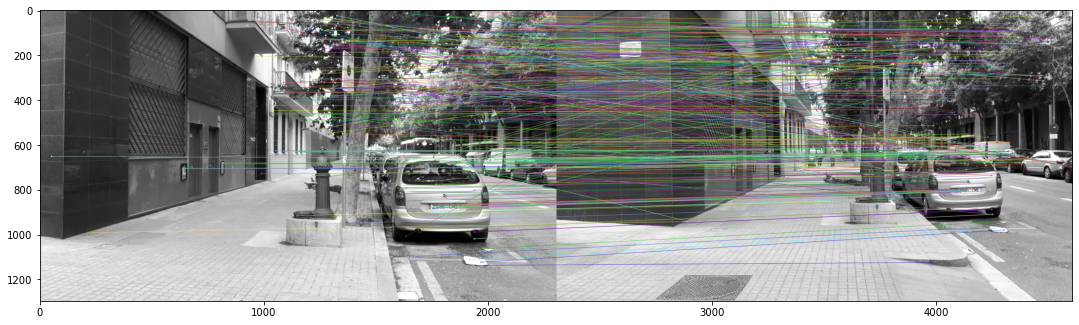

total number of points pts1 and pts2:  (369, 3) (369, 3)
[[16498.7424327   1337.61340352]
 [  932.90698134   963.98844082]]
X [4.75483802 0.31803762 7.68370157 1.        ]
curret 0.3180376239741418
(4, 369)
(150, 4)
[ 0.24395897 -0.67864443  3.30910054  1.        ]


array([[ 4.75483802,  4.75483802,  0.24395897, ..., 11.08818563,
         0.83521593, -0.70290609],
       [ 0.31803762,  0.31803762, -0.67864443, ..., -0.61651358,
        -1.03536624,  0.10870447],
       [ 7.68370157,  7.68370157,  3.30910054, ..., 25.9322067 ,
         5.04574136, -1.49985417],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [171]:
# complete ...v??1st and 3rd vi 

# plot the reconstructed 3D points
# images 1 and 2
img1 = cv2.imread('images/eview1.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('images/eview3.jpg',cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('images/eview2.jpg',cv2.IMREAD_GRAYSCALE)
F12 = computeFundamentalMatrix(img1, img2)
K = compute_K()
E = compute_E(F12, K)
P1 = compute_P1(K)
Pc2 = compute_P2(E, K)
P2 = chose_right_P2(P1, Pc2, pts1_12.T, pts2_12.T)
img1_rgb = cv2.imread('images/eview1.jpg',cv2.COLOR_BGR2RGB)
triangulate_all_matches(pts1_12.T, pts2_12.T, P1, P2, width, height, img1_rgb)

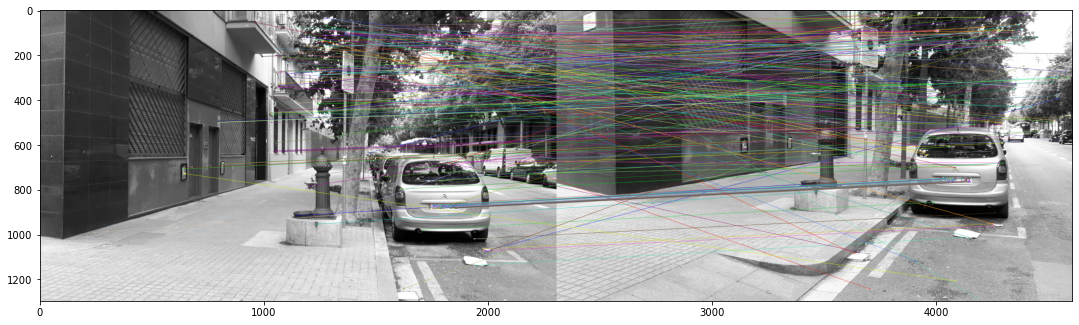

total number of points pts1 and pts2:  (240, 3) (240, 3)
[[16498.7424327   1337.61340352]
 [  932.90698134   963.98844082]]
X [1.02271616 0.12133301 1.56342759 1.        ]
curret 0.12133301457434649
(4, 369)
(317, 4)
[1.02271616 0.12133301 1.56342759 1.        ]


array([[ 1.02271616e+00,  1.02271616e+00, -1.80501090e+00, ...,
         8.90029986e-01,  1.32151015e+00,  5.96212042e-01],
       [ 1.21333015e-01,  1.21333015e-01,  5.76602702e+00, ...,
         7.67846966e-02, -9.06403272e-01, -1.61270899e-02],
       [ 1.56342759e+00,  1.56342759e+00, -7.73491716e+01, ...,
         1.83611791e+00,  1.09961634e+01,  1.67850344e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00]])

In [172]:
# images 1 and 3
F13 = computeFundamentalMatrix(img1, img3)
K = compute_K()
E = compute_E(F13, K)
P1 = compute_P1(K)
Pc2 = compute_P2(E, K)
P2 = chose_right_P2(P1, Pc2, pts1_12.T, pts2_12.T)
img1 = cv2.imread('images/eview1.jpg',cv2.COLOR_BGR2RGB)
triangulate_all_matches(pts1_12.T, pts2_12.T, P1, P2, width, height, img1)

In [ ]:
# plot camera 1 (reference camera) in black
# plot camera 2 in blue
# plot camera 3 in red (normalize the projection matrix P3 dividing by P3[2,2])

## References

[1] José Lezama, Rafael Grompone von Gioi, Gregory Randall, and Jean-Michel Morel. Finding vanishing points via point alignments in image primal and dual domains. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, pages 509–515, 2014.

[2] José Lezama, Gregory Randall, and Rafael Grompone von Gioi. Vanishing Point Detection in Urban Scenes Using Point Alignments. Image Processing On Line, 7:131–164, 2017.

[3] Johannes Lutz Schönberger and Jan-Michael Frahm. Structure-from-motion revisited. In Conference on Computer Vision and Pattern Recognition (CVPR), 2016.

[4] Gilles Simon, Antoine Fond, and Marie-Odile Berger. A simple and effective method to detect orthogonal vanishing points in uncalibrated images of man-made environments. In Eurographics, 2016.

[5] Richard Szeliski. Computer vision: algorithms and applications. Springer Science & Business Media, 2010.

[6] Yichao Zhou, Haozhi Qi, Jingwei Huang, and Yi Ma. Neurvps: Neural vanishing point scanning via conic convolution. NeurIPS 2019. 